#Part 3. Changing the tune through the NLL magnet - Influence on the Invariants

This is part 3 in the notebook series investigating how the single particle invariants change with increase particle amplitude (or bunch generalized emittance). See [Part 1 - Comparing Full Chef to Linear Dynamics](IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT1 - Comparing Full chef to linear dynamics.ipynb) for a look at how the nonlinear aspects of "linear" lattice elements may affect the invariant. See [Part 2 -  Slicing the Nonlinear Magnet in MADX](IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT 2 - Increasing the magnet slices) for a look at how further refinement/slicing of the nonlinear magnet can influence the particle motion.

The testing in part 1 showed a strong reduction in the number of outliers from our bunch (those particles with extremely large deviations from the mean invariant over the 100 turns). The result was a significant reduction in the standard deviation of the 2nd invariant - from ~16% down to 3% - and an additional reduction in the Hamiltonian (1st invariant) - from 3.1% down to 2.4%. 

The testing in part 2 made clear that the nonlinear potential is well described using 20 total slices. Increasing the number of slices to 40 made very little difference in the statistical spread of the single particle invariants, as the mean values remained the same, and standard deviations of 2.4% in H and 3.1% in I remained.

**This has led us to consider an additional possibility**: the nonlinear Hamiltonian specified by the IOTA lattice is not fully integrable. Rather, there are higher order terms stemming from the potential which are of $O(\nu^3)$. These terms, for a tune spread of $\nu = 0.3$ in the NL element, predict an additional "error" of $\sim 3 \%$ in the invariants.


####Execution
**For this notebook, we will consider a NL element with larger tune.** I will construct such an element using the IOTA madx script. I will then calculate an R-matrix which will approximate the remainder of the IOTA lattice. I will then construct an appropriately matched bunch with generalized emittance of approximately 10 mm-mrad, and I will run with for ~100 turns with 1000 macro particles.

The adjusted nonlinear element has twice the length and twice the phase advance. I still constructed it with 40 slices, to maintain similar resolution to the original (20 slices per 1.8 m). It is stored in the file `nll_40slices_0pt6_tune.madx`.

In [5]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [6]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 17/08/2015 

CPython 2.7.10
IPython 3.1.0


In [7]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from elliptic import EllipticBeam6D
from base_diagnostics import lfplot

In [10]:
lattice = synergia.lattice.MadX_reader().get_lattice("base_nll", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/nll_40slices_0pt5_tune.madx")
#lattice2 = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_1IO_center.madx")


for elem in lattice.get_elements():
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")

nsteps_per_element = 10
nsteps = len(lattice.get_elements())*nsteps_per_element
        
name = 'Double-tune-NLL'
order = 1
outputdir = 'order_'+str(order)+'_'+name

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.macro_particles=1000
#opts.emitx = 1.0e-5
#workflow.make_path(outputdir)


stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

#stepper2 = synergia.simulation.Independent_stepper_elements(lattice2, opts.map_order, opts.steps_per_element)
#lattice_simulator2 = stepper2.get_lattice_simulator()

###Construct the R-matrix needed to complement the new NLL drift.

The modificaiton to the drift length and tune necessitates a change in the R-matrix used to represent the remainder of the IOTA lattice (to 1st order). First, I will calculate the focal length, minimum beta function, and entrance twiss parameters for the new drift section.

In [261]:
def get_base_nll(nn, l0, mu0, t, c):
    '''Construct base drift values for the nonlinear element. Taken from madx script by A. Valishev.
    
    '''
    #musect=mu0+0.5;
    f0=l0/4.0*(1.0+1.0/np.tan(np.pi*mu0)**2); #focal length
    betae=l0/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #entrance beta function
    alphae=l0/2.0/f0/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #entrance alpha function
    betas=l0*(1-l0/4.0/f0)/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #middle beta function
    #value,f0,betae,alfae,betas;
    
    return [f0, betae,alphae,betas]

A quick comparison using the old parameters (l = 1.8m and tune = 0.3) shows that we have nice agreement.

In [36]:
old_tune = 0.3
lnll0 = 1.8
nseg = 40
t = 0.4
c = 0.01
vals0 = get_base_nll(nseg, lnll0, old_tune, t, c)
print vals0

[0.68753882025018942, 1.8926320036288808, 1.3763819204711731, 0.65388827520482495]


The focal length is given by $f_0 = 0.68753882025018942$, and as such the R-matrix should depict focusing with element values of $-1/f$ in the lower left element of the 2x2 matrices in x and y. We found previously a value of $-1.4545$, as expected.

In [40]:
new_tune = 0.6
lnll = 3.6
nseg = 40
t = 0.4
c = 0.01
vals = get_base_nll(nseg, lnll, new_tune, t, c)
print vals

[0.99501552810007565, 6.1246858201346921, 3.0776835371752562, 0.58485545321923105]


We have agreement in twiss parameters with those that madx calculates for the new drift ($\beta_* = 0.5849$, $\beta_e = 6.1247$ and $\alpha_e = 3.0777$.

The new focal length is $f_0 = 0.995$, so our R-matrix has a very simple form with R ~ -1. I will include a very similar R56 component to the full IOTA lattice.

In [57]:
from base_diagnostics import latticework
fnew = vals[0]
toy_R = latticework.make_R(fnew)
print toy_R[0:2,0:2]
print toy_R[2:4,2:4]
print toy_R[4:6,4:6]

[[ 1.          0.        ]
 [-1.00500944  1.        ]]
[[ 1.          0.        ]
 [-1.00500944  1.        ]]
[[ 1.   3.2]
 [ 0.   1. ]]


###Construct the turn_end_action operator

In [58]:
class Pickle_helper:
    __getstate_manages_dict__ = 1
    def __init__(self, *args):
        self.args = args
    def __getinitargs__(self):
        return self.args
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, state):
        self.__dict__ = state

class turn_actions(synergia.simulation.Propagate_actions, Pickle_helper):
    def __init__(self, mat):
        synergia.simulation.Propagate_actions.__init__(self)
        Pickle_helper.__init__(self, mat)
        self.matrix = mat #R-matrix being imported
    def turn_end_action(self, stepper, bunch, turn_num):
        '''Move particles through a single drift and advance the reference particle by the drift length'''
        
        #define matrix
        R_matrix = self.matrix
        
        particles = bunch.get_local_particles();
        for particle in particles:
            new_particle = np.dot(R_matrix,particle[0:6]) #This is for full 6x6 multiplication, not using currently.
            
            #just perform x+y-plane updates
            #new_particle = np.zeros(6)
            #new_particle[0:2] = np.dot(R_matrix[0:2,0:2],particle[0:2])
            #new_particle[2:4] = np.dot(R_matrix[2:4,2:4],particle[2:4])
            particle[0:6] = new_particle

#construct the operator using our toy R matrix
turn_action = turn_actions(toy_R)

Construct a bunch consisting of a single test particle.

In [60]:
from elliptic import EllipticBeam6D
from elliptic import ellipticBeam
from scipy import constants as consts

gamma0 = 2.
speciesMass = consts.m_p
dgammaOgamma = 1.e-3
#We want dpop no dE/E
dpop = opts.dpop
#Assume Gaussian longitudinal profile - put bunch length in m
sigmaz = opts.stdz
transverseEmittance = opts.emit_transverse
numMacroParticles = 1

t = 0.4 #fixed for IOTA 6-6 for now
c = 0.01 #fixed for IOTA 6-6 for now

#calculate beta at injection - center of NL element
#beta = lf0.beta_x
#betaPrime = -2*lf0.alpha_x
beta = 0.5848554532
betaPrime = 0.0

xOffset = 0. #m
yOffset = 0. #m

# Do not modify below this line
E0 = gamma0 * consts.m_p * consts.c**2 * 6.24150934e9 #GeV/J
ESpread = E0 * dgammaOgamma


#myBunchGenerator = ellipticBeam.ellipticBeam(t, c, beta, betaPrime)
#bunch = myBunchGenerator.generateBunch(transverseEmittance, numMacroParticles)
ref = lattice.get_reference_particle()
bucket_length = 1
real_particles = 1.e10
num_total_particles = 1
comm = synergia.utils.Commxx(True)
myBunch = synergia.bunch.Bunch(ref,num_total_particles, real_particles, comm, bucket_length)

particle = np.array([1.e-3,0.,1.e-3,0.,0.,0.,1.])
local_particle = myBunch.get_local_particles()
local_particle[:,:] = particle

myBunch.dpop = 0

In [63]:
# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_step(diagnostics)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag)

Remember to invoke the turn_end_action operator when propagating!

In [64]:
opts.turns = 100
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, turn_action,
                     opts.turns, opts.maxturns,opts.verbosity)

#clean up files
workflow.cleanup(opts.output_dir)

###Diagnostics

To work with the combination of a short lattice segment + R-matrix, I've created adjusted functions prefixed by the word "toy" to denote the use of this toy model approach. These functions specify fixed twiss parametes at the location of particle extraction, rather than grabbing values from the lattice simulator.

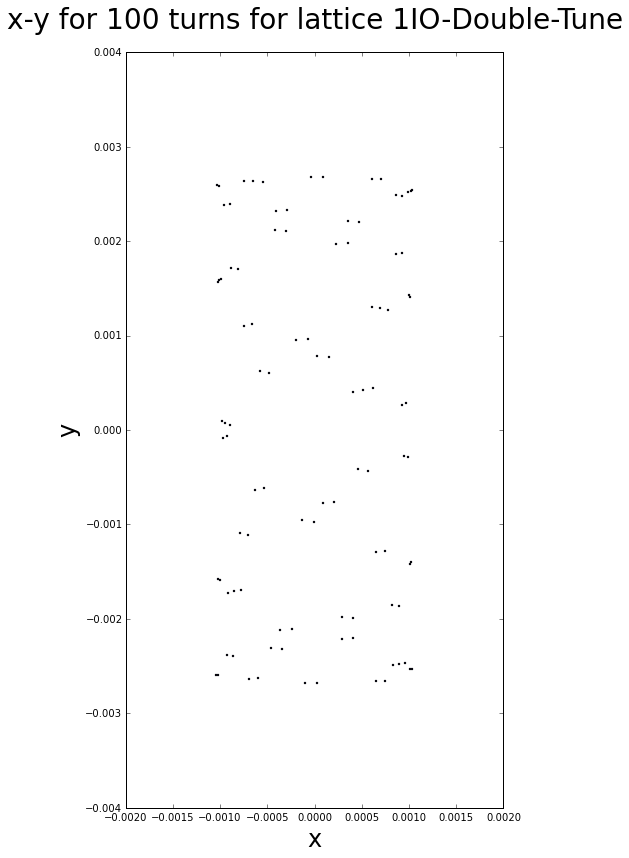

In [246]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-Double-Tune'
popts.ID = None
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['x','y']
popts.num = 1
popts.scale = 2
popts.plot_lost = False

singleparticle.toy_plot_Poincare(popts,vals)

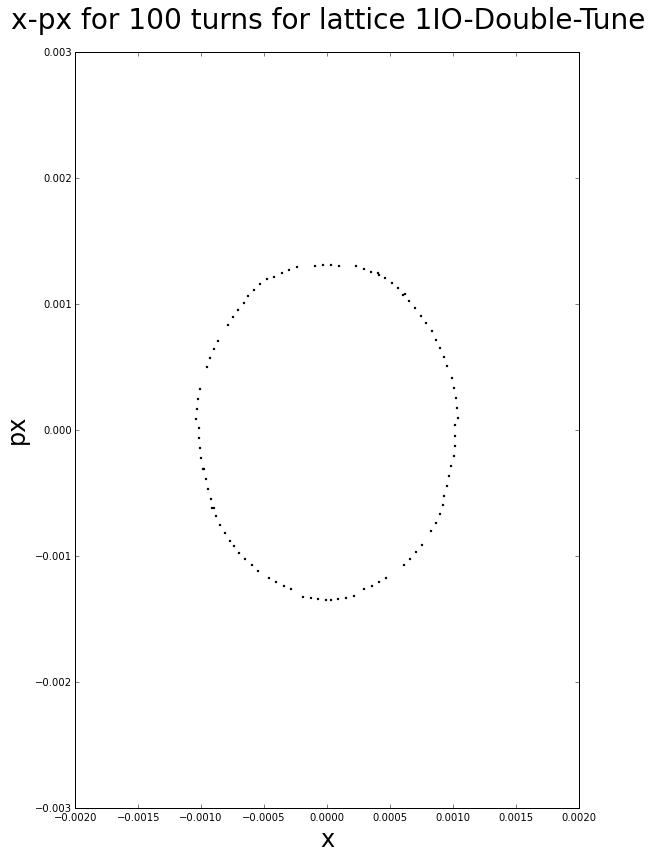

In [254]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-Double-Tune'
popts.ID = None
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['x','px']
popts.num = 1
popts.scale = 2
popts.plot_lost = False

singleparticle.toy_plot_Poincare(popts,vals)

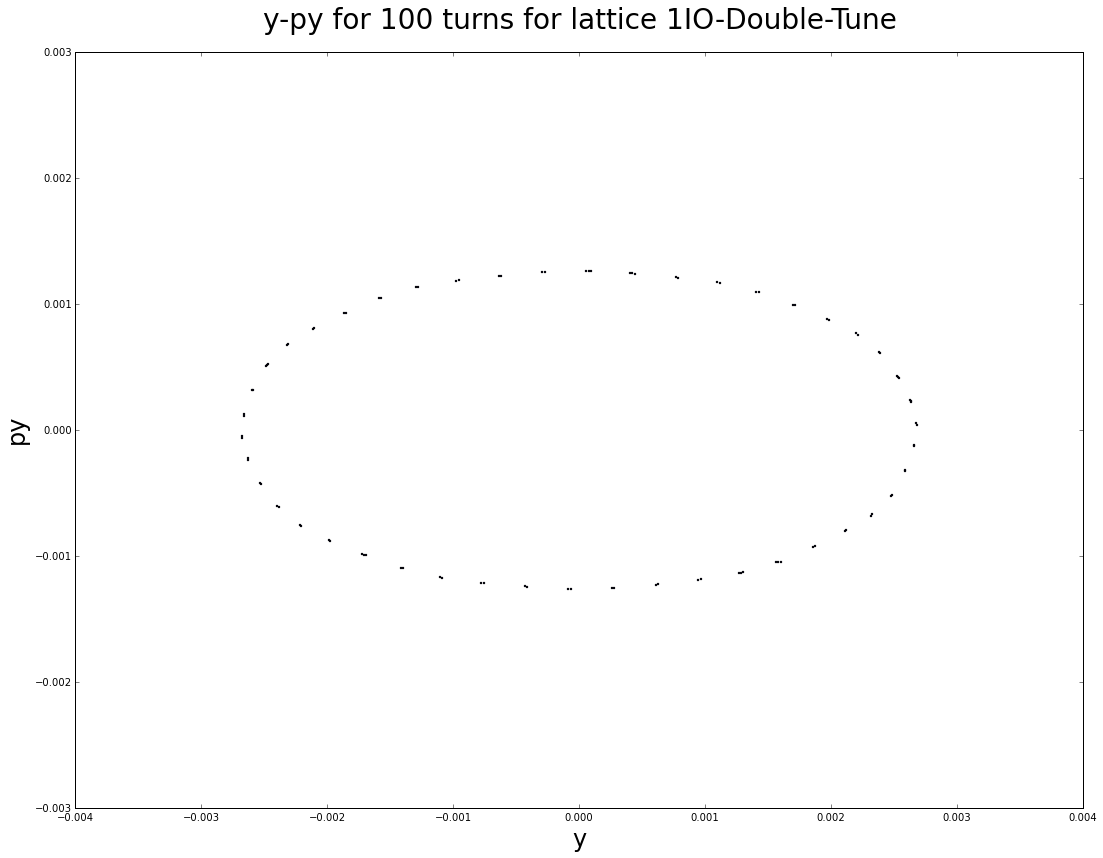

In [253]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-Double-Tune'
popts.ID = None
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['y','py']
popts.num = 1
popts.scale = 2
popts.plot_lost = False

singleparticle.toy_plot_Poincare(popts,vals)

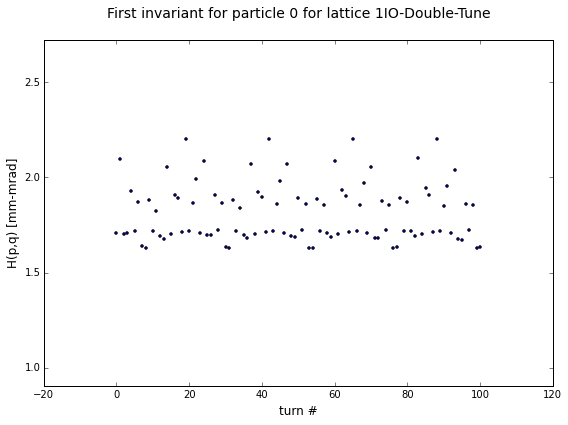

In [255]:
#popts.lattice_simulator = stepper.get_lattice_simulator()
popts.num = 1
popts.ID = 0
popts.variance = .5
popts.save = False
singleparticle.toy_plot_elliptic_Invariant(popts, vals)
#singleparticle.plot_H_I(popts)

In [256]:
popts.macro_particles = opts.macro_particles
hArray = singleparticle.toy_calc_elliptic_Invariant(popts, vals)
#singleparticle.stats_Invariant(hArray,popts)

In [257]:
hvals = hArray[::,0]
ivals = hArray[::,1]

hmean = np.mean(hvals)
imean = np.mean(ivals)

hstd = (np.std(hvals)/hmean)*100
istd = (np.std(ivals)/imean)*100

print "H std: " + str(hstd)
print "I std: " + str(istd)

H std: 8.38071004336
I std: 11.5793050599


It looks liike the variation has increased, as expected! A key point of emphasis is that this variation exists even for a test particle with low generalized emittance! That is, the reduction in preservation of the invariants with increasing particle amplitude which I noted in the last notebook is not a factor here, and we may conclude that it is a separate effect from the tune-dependence. Nonetheless,we still need to re-run this toy model with a matched bunch of larger generalized emittance to test a more realistic bunch.

###Can be ignored - A quick double check with streamlined methods.

In [258]:
files = singleparticle.get_file_list(popts)
twiss = singleparticle.get_toy_twiss(vals, popts.lattice)

normalc = []
#t2 = twiss[:-1,:]
for inputfile in files:
    header, particles = singleparticle.get_particles(inputfile)
    norm_coords = singleparticle.normalized_coordinates(header, particles, twiss).flatten()
    normalc.append(norm_coords)
normalized = np.asarray(normalc)

xs = normalized[::,0]
xps = normalized[::,1]
ys = normalized[::,2]
yps = normalized[::,3]

popts.t = 0.4
popts.c = 0.01
u,v = singleparticle.elliptic_coordinates(normalized, popts)
hvals = singleparticle.single_particle_hamiltonian(normalized) + singleparticle.elliptic_hamiltonian(u,v,popts)

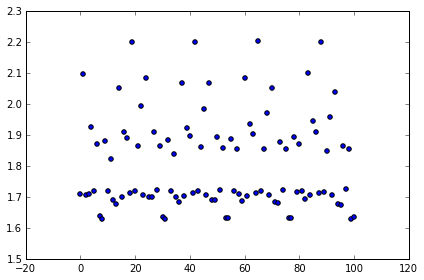

In [259]:
plt.scatter(ss, hvals*1.e6)

We appear to have consistent behavior. I will tentatively trust my adjusted "toy" scripts.